# FuzSemCom Project - Complete Pipeline Notebook

Notebook này thực thi toàn bộ pipeline của dự án **Fuzzy Logic-based Semantic Communication** theo paper ICC 2026.

## Cấu trúc Pipeline:
1. **Data Exploration** - Phân tích dữ liệu ban đầu
2. **Data Preprocessing** - Làm sạch và tiền xử lý
3. **Ground Truth Generation** - Tạo nhãn và chia train/test
4. **FSE Evaluation** - Đánh giá Fuzzy Semantic Encoder
5. **DeepSC Comparison** - So sánh với L-DeepSC
6. **Ablation Study** - Tối ưu hóa với Bayesian Optimization
7. **Encode/Decode Demo** - Demo mã hóa 2-byte semantic symbols

---


In [1]:
# Import các thư viện cần thiết
import sys
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Thiết lập đường dẫn project
# Notebook nằm trong jupyter/, nên cần lên 1 level để đến project root
PROJECT_ROOT = Path.cwd()
# Nếu đang ở trong jupyter/, cần lên 1 level
if PROJECT_ROOT.name == "jupyter":
    PROJECT_ROOT = PROJECT_ROOT.parent
# Hoặc kiểm tra xem có folder src không
if not (PROJECT_ROOT / "src").exists():
    # Thử lên 1 level nữa
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Import các module của dự án
from fuzzy_engine import FuzzyEngine, SEMANTIC_CLASSES
from ground_truth_generator import GroundTruthGenerator

# Thiết lập thư mục output cho notebook
NOTEBOOK_OUTPUT_DIR = PROJECT_ROOT / "results" / "notebook_outputs_copy"
NOTEBOOK_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Đã import các thư viện và thiết lập đường dẫn")
print(f"✓ PROJECT_ROOT: {PROJECT_ROOT}")
print(f"✓ Thư mục output: {NOTEBOOK_OUTPUT_DIR}")
print(f"✓ Kiểm tra src folder: {(PROJECT_ROOT / 'src').exists()}")

✓ Đã import các thư viện và thiết lập đường dẫn
✓ PROJECT_ROOT: /home/nhannv02/Hello/fuzsemcom_project_readme
✓ Thư mục output: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy
✓ Kiểm tra src folder: True


## STEP 1: DATA EXPLORATION

Phân tích dữ liệu ban đầu để hiểu cấu trúc, missing values, và phân bố của các cảm biến.


In [2]:
# Load dữ liệu raw
RAW_DATA = PROJECT_ROOT / "data" / "raw" / "Agriculture_dataset_with_metadata.csv"

if not RAW_DATA.exists():
    print(f"❌ Không tìm thấy file: {RAW_DATA}")
    print("Vui lòng đảm bảo file dữ liệu đã được đặt đúng vị trí.")
else:
    df_raw = pd.read_csv(RAW_DATA)
    print(f"✓ Đã load dữ liệu: {df_raw.shape[0]} samples × {df_raw.shape[1]} features")
    print(f"\nCác cột cảm biến chính:")
    SENSOR_COLUMNS = ["Moisture", "pH", "N", "Temperature", "Humidity"]
    for col in SENSOR_COLUMNS:
        if col in df_raw.columns:
            print(f"  - {col}")
    
    # Hiển thị 5 dòng đầu
    print(f"\n📊 Preview dữ liệu (5 dòng đầu):")
    display(df_raw[SENSOR_COLUMNS + ["NDI_Label", "PDI_Label"]].head())


✓ Đã load dữ liệu: 60000 samples × 24 features

Các cột cảm biến chính:
  - Moisture
  - pH
  - N
  - Temperature
  - Humidity

📊 Preview dữ liệu (5 dòng đầu):


,Moisture,pH,N,Temperature,Humidity,NDI_Label,PDI_Label
0,9.79,7.43,43,30.75,41.97,Medium,Medium
1,12.13,5.50,65,28.02,55.65,High,High
2,11.28,7.82,29,29.46,55.73,Low,Low
3,31.48,5.88,47,33.25,93.94,Medium,Low
4,26.75,6.00,67,29.17,36.19,Medium,Low


📊 Missing Values Analysis:
Tổng số cột có missing: 4

Top 10 cột có nhiều missing nhất:


,Missing Count
Migration_Timestamp,54065
NDVI,30108
NDRE,30108
RGB_Damage_Score,29892


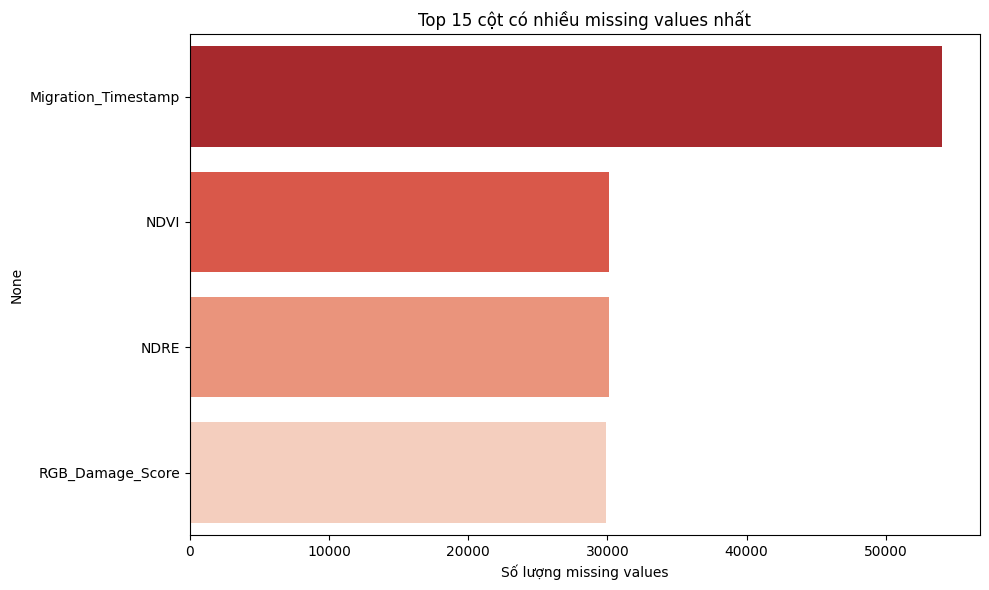

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/missing_values.png


In [3]:
# Phân tích missing values
missing = df_raw.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("📊 Missing Values Analysis:")
    print(f"Tổng số cột có missing: {len(missing)}")
    print("\nTop 10 cột có nhiều missing nhất:")
    display(missing.head(10).to_frame("Missing Count"))
    
    # Vẽ biểu đồ missing values
    plt.figure(figsize=(10, 6))
    top_missing = missing.head(15)
    sns.barplot(x=top_missing.values, y=top_missing.index, palette="Reds_r")
    plt.xlabel("Số lượng missing values")
    plt.title("Top 15 cột có nhiều missing values nhất")
    plt.tight_layout()
    missing_plot_path = NOTEBOOK_OUTPUT_DIR / "missing_values.png"
    plt.savefig(missing_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ: {missing_plot_path}")
else:
    print("✓ Không có missing values trong dữ liệu")


📊 Thống kê mô tả các cảm biến:


,Moisture,pH,N,Temperature,Humidity
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,23.000997,6.502081,44.398033,30.010243,60.003572
std,8.671953,0.865773,17.354911,6.946910,20.129559
min,8.000000,5.000000,15.000000,18.000000,25.000000
25%,15.450000,5.750000,29.000000,23.980000,42.580000
50%,23.040000,6.500000,44.000000,30.000000,59.970000
75%,30.500000,7.250000,59.000000,36.060000,77.370000
max,38.000000,8.000000,74.000000,42.000000,95.000000


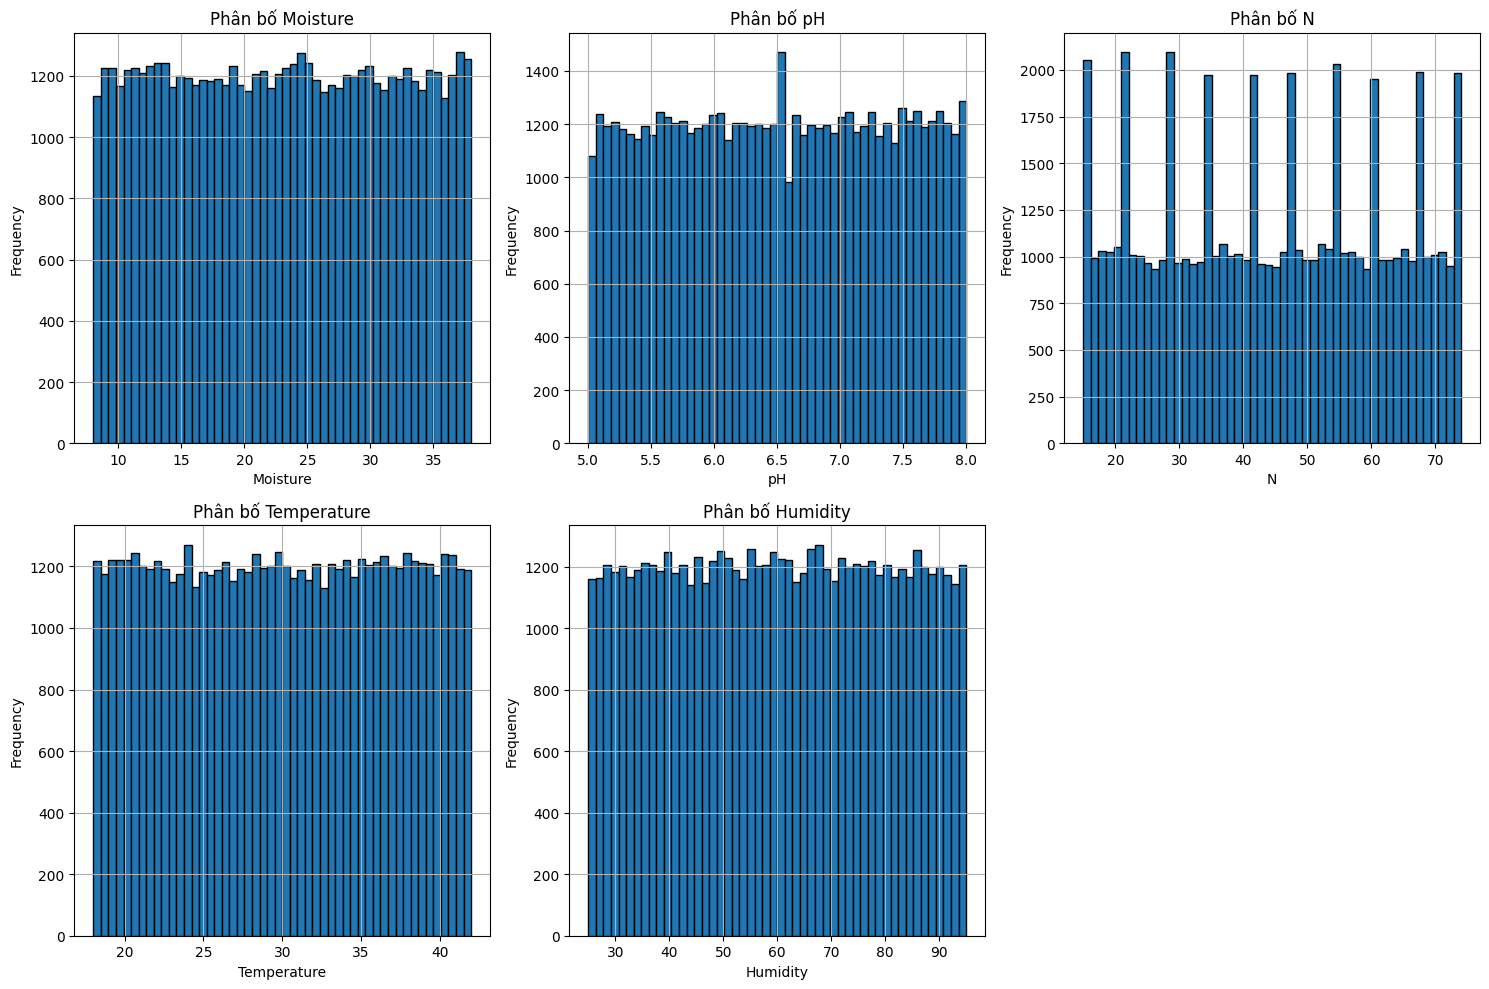

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/sensor_distributions.png


In [4]:
# Thống kê mô tả các cảm biến
print("📊 Thống kê mô tả các cảm biến:")
stats = df_raw[SENSOR_COLUMNS].describe()
display(stats)

# Vẽ phân bố các cảm biến
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(SENSOR_COLUMNS):
    if col in df_raw.columns:
        df_raw[col].hist(bins=50, ax=axes[idx], edgecolor='black')
        axes[idx].set_title(f'Phân bố {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

# Ẩn subplot thừa
axes[5].axis('off')

plt.tight_layout()
dist_plot_path = NOTEBOOK_OUTPUT_DIR / "sensor_distributions.png"
plt.savefig(dist_plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ: {dist_plot_path}")


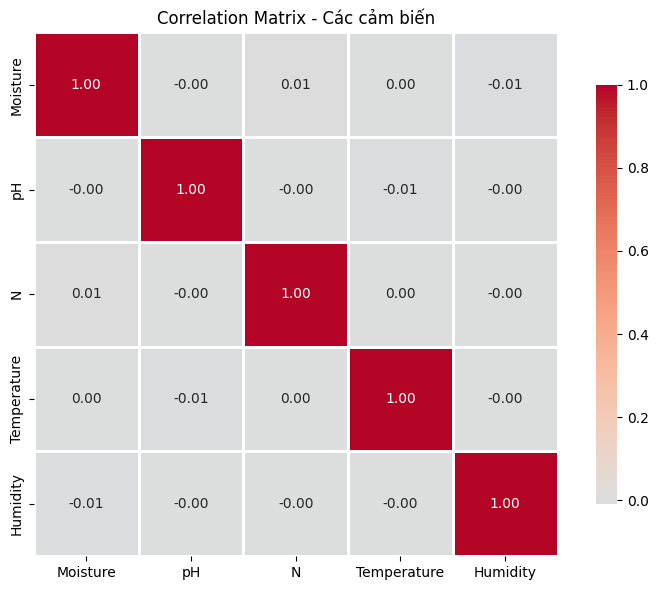

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/correlation_matrix.png

📊 Correlation Matrix:


,Moisture,pH,N,Temperature,Humidity
Moisture,1.000000,-0.001831,0.007123,0.000565,-0.008582
pH,-0.001831,1.000000,-0.001154,-0.005458,-0.003430
N,0.007123,-0.001154,1.000000,0.002725,-0.003434
Temperature,0.000565,-0.005458,0.002725,1.000000,-0.000008
Humidity,-0.008582,-0.003430,-0.003434,-0.000008,1.000000


In [5]:
# Phân tích correlation giữa các cảm biến
corr_matrix = df_raw[SENSOR_COLUMNS].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix - Các cảm biến")
plt.tight_layout()
corr_plot_path = NOTEBOOK_OUTPUT_DIR / "correlation_matrix.png"
plt.savefig(corr_plot_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ: {corr_plot_path}")

# Hiển thị correlation matrix dạng bảng
print("\n📊 Correlation Matrix:")
display(corr_matrix)


## STEP 2: DATA PREPROCESSING

Làm sạch dữ liệu, loại bỏ missing values và outliers, mapping NDI/PDI labels sang semantic symbols.


In [6]:
# Load script preprocessing (hoặc tự implement logic)
PREPROCESSED_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_preprocessed.csv"

if PREPROCESSED_DATA.exists():
    df_preprocessed = pd.read_csv(PREPROCESSED_DATA)
    print(f"✓ Đã load dữ liệu đã preprocess: {df_preprocessed.shape[0]} samples")
else:
    print("⚠️ Chưa có file preprocessed. Đang chạy preprocessing...")
    # Logic preprocessing đơn giản
    df_preprocessed = df_raw.copy()
    
    # Loại bỏ missing values ở các cột cảm biến
    before = len(df_preprocessed)
    df_preprocessed = df_preprocessed.dropna(subset=SENSOR_COLUMNS)
    after_dropna = len(df_preprocessed)
    
    # Filter theo valid ranges
    VALID_RANGES = {
        "Moisture": (0, 100),
        "pH": (4.0, 9.0),
        "N": (0, 300),
        "Temperature": (10, 45),
        "Humidity": (20, 100),
    }
    
    for col, (low, high) in VALID_RANGES.items():
        df_preprocessed = df_preprocessed[(df_preprocessed[col] >= low) & (df_preprocessed[col] <= high)]
    
    after_range = len(df_preprocessed)
    df_preprocessed = df_preprocessed.reset_index(drop=True)
    
    print(f"  - Trước: {before} samples")
    print(f"  - Sau dropna: {after_dropna} samples")
    print(f"  - Sau filter range: {after_range} samples")
    print(f"  - Loại bỏ: {before - after_range} samples ({100*(before-after_range)/before:.1f}%)")

print(f"\n📊 Preview dữ liệu sau preprocessing:")
display(df_preprocessed[SENSOR_COLUMNS + ["NDI_Label", "PDI_Label", "semantic_label"]].head() if "semantic_label" in df_preprocessed.columns else df_preprocessed[SENSOR_COLUMNS + ["NDI_Label", "PDI_Label"]].head())


✓ Đã load dữ liệu đã preprocess: 60000 samples

📊 Preview dữ liệu sau preprocessing:


,Moisture,pH,N,Temperature,Humidity,NDI_Label,PDI_Label,semantic_label
0,9.79,7.43,43,30.75,41.97,Medium,Medium,heat_stress
1,12.13,5.50,65,28.02,55.65,High,High,water_deficit_acidic
2,11.28,7.82,29,29.46,55.73,Low,Low,water_deficit_alkaline
3,31.48,5.88,47,33.25,93.94,Medium,Low,other
4,26.75,6.00,67,29.17,36.19,Medium,Low,other


📊 Phân bố Semantic Labels:


,Count
semantic_label,
other,14649
nutrient_deficiency,11646
water_deficit_acidic,11573
water_deficit_alkaline,7331
fungal_risk,6787
heat_stress,5037
alkaline_soil,1516
acidic_soil,1427
optimal,34


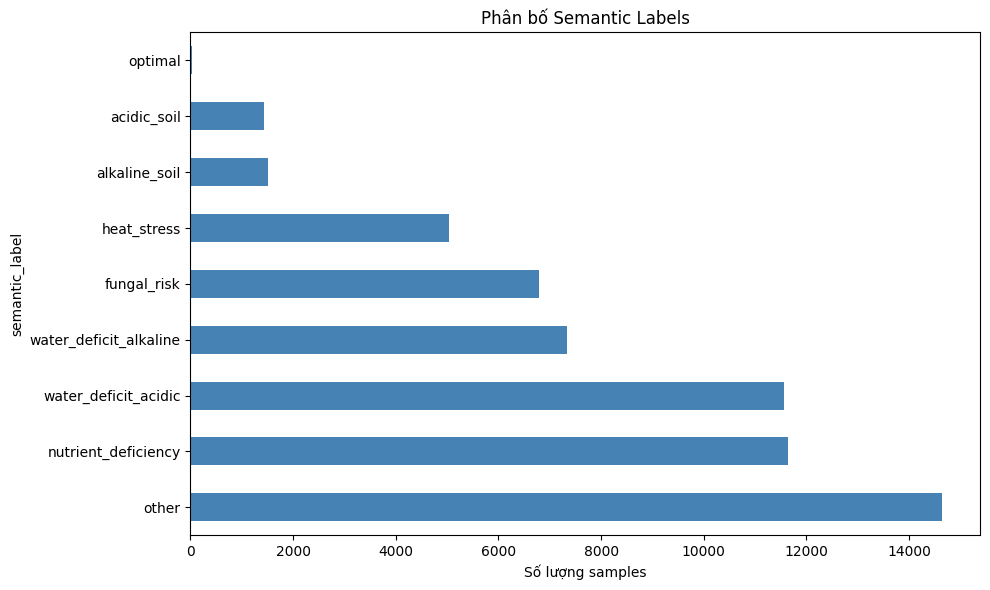

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/label_distribution.png

📊 Phân bố NDI_Label:


,Count
NDI_Label,
Medium,30016
High,15044
Low,14940



📊 Phân bố PDI_Label:


,Count
PDI_Label,
Low,30123
Medium,17936
High,11941


In [7]:
# Phân tích phân bố semantic labels (nếu có)
if "semantic_label" in df_preprocessed.columns:
    label_dist = df_preprocessed["semantic_label"].value_counts()
    print("📊 Phân bố Semantic Labels:")
    display(label_dist.to_frame("Count"))
    
    # Vẽ biểu đồ phân bố
    plt.figure(figsize=(10, 6))
    label_dist.plot(kind='barh', color='steelblue')
    plt.xlabel("Số lượng samples")
    plt.title("Phân bố Semantic Labels")
    plt.tight_layout()
    label_dist_plot_path = NOTEBOOK_OUTPUT_DIR / "label_distribution.png"
    plt.savefig(label_dist_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ: {label_dist_plot_path}")
    
    # Phân bố NDI/PDI
    if "NDI_Label" in df_preprocessed.columns:
        print("\n📊 Phân bố NDI_Label:")
        display(df_preprocessed["NDI_Label"].value_counts().to_frame("Count"))
    
    if "PDI_Label" in df_preprocessed.columns:
        print("\n📊 Phân bố PDI_Label:")
        display(df_preprocessed["PDI_Label"].value_counts().to_frame("Count"))


## STEP 3: GROUND TRUTH GENERATION

Tạo ground truth labels sử dụng hard-coded rules, sau đó chia train/test 80/20 với stratified sampling.


In [8]:
# Load dữ liệu đã preprocess (hoặc dùng df_preprocessed từ cell trước)
FUZZY_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_fuzzy.csv"
TRAIN_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_train.csv"
TEST_DATA = PROJECT_ROOT / "data" / "processed" / "semantic_dataset_test.csv"

if FUZZY_DATA.exists() and TRAIN_DATA.exists() and TEST_DATA.exists():
    print("✓ Đã có dữ liệu ground truth và train/test splits")
    df_fuzzy = pd.read_csv(FUZZY_DATA)
    df_train = pd.read_csv(TRAIN_DATA)
    df_test = pd.read_csv(TEST_DATA)
    
    print(f"\n📊 Thống kê dataset:")
    print(f"  - Full dataset: {len(df_fuzzy)} samples")
    print(f"  - Train set: {len(df_train)} samples ({100*len(df_train)/len(df_fuzzy):.1f}%)")
    print(f"  - Test set: {len(df_test)} samples ({100*len(df_test)/len(df_fuzzy):.1f}%)")
else:
    print("⚠️ Chưa có dữ liệu ground truth. Đang tạo...")
    # Tạo ground truth
    generator = GroundTruthGenerator()
    labels = generator.generate(df_preprocessed)
    df_fuzzy = df_preprocessed.copy()
    df_fuzzy["ground_truth_id"] = labels
    df_fuzzy = df_fuzzy[df_fuzzy["ground_truth_id"] >= 0].reset_index(drop=True)
    df_fuzzy["ground_truth_label"] = df_fuzzy["ground_truth_id"].map(lambda idx: SEMANTIC_CLASSES[idx])
    
    # Chia train/test
    stratify_col = df_fuzzy["ground_truth_label"] if df_fuzzy["ground_truth_label"].nunique() > 1 else None
    df_train, df_test = train_test_split(
        df_fuzzy,
        test_size=0.2,
        random_state=42,
        stratify=stratify_col,
    )
    
    print(f"✓ Đã tạo ground truth và chia train/test")
    print(f"  - Full dataset: {len(df_fuzzy)} samples")
    print(f"  - Train set: {len(df_train)} samples")
    print(f"  - Test set: {len(df_test)} samples")


✓ Đã có dữ liệu ground truth và train/test splits

📊 Thống kê dataset:
  - Full dataset: 40942 samples
  - Train set: 32753 samples (80.0%)
  - Test set: 8189 samples (20.0%)


📊 Phân bố Ground Truth Labels (Full Dataset):


,Count
ground_truth_label,
nutrient_deficiency,15036
water_deficit_acidic,8646
heat_stress,6332
water_deficit_alkaline,5473
acidic_soil,3176
alkaline_soil,1961
fungal_risk,284
optimal,34


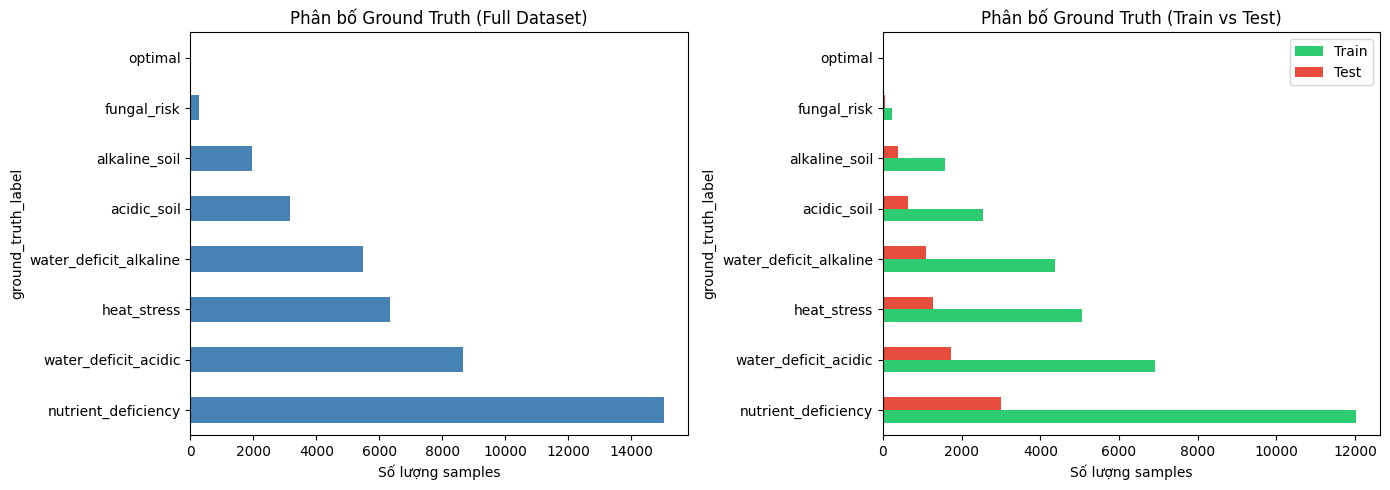

✓ Đã lưu biểu đồ: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/ground_truth_distribution.png

📊 Phân bố Train/Test:


,Train %,Test %
ground_truth_label,,
nutrient_deficiency,36.73,36.72
water_deficit_acidic,21.12,21.11
heat_stress,15.46,15.47
water_deficit_alkaline,13.37,13.37
acidic_soil,7.76,7.75
alkaline_soil,4.79,4.79
fungal_risk,0.69,0.70
optimal,0.08,0.09


In [9]:
# Phân tích phân bố ground truth labels
if "ground_truth_label" in df_fuzzy.columns:
    print("📊 Phân bố Ground Truth Labels (Full Dataset):")
    gt_dist = df_fuzzy["ground_truth_label"].value_counts()
    display(gt_dist.to_frame("Count"))
    
    # Vẽ biểu đồ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Full dataset
    gt_dist.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_xlabel("Số lượng samples")
    ax1.set_title("Phân bố Ground Truth (Full Dataset)")
    
    # Train/Test split
    train_dist = df_train["ground_truth_label"].value_counts()
    test_dist = df_test["ground_truth_label"].value_counts()
    
    comparison_df = pd.DataFrame({
        'Train': train_dist,
        'Test': test_dist
    }).fillna(0)
    comparison_df.plot(kind='barh', ax=ax2, color=['#2ecc71', '#e74c3c'])
    ax2.set_xlabel("Số lượng samples")
    ax2.set_title("Phân bố Ground Truth (Train vs Test)")
    ax2.legend()
    
    plt.tight_layout()
    gt_dist_plot_path = NOTEBOOK_OUTPUT_DIR / "ground_truth_distribution.png"
    plt.savefig(gt_dist_plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ: {gt_dist_plot_path}")
    
    # Thống kê train/test
    print("\n📊 Phân bố Train/Test:")
    train_pct = train_dist / len(df_train) * 100
    test_pct = test_dist / len(df_test) * 100
    comparison_pct = pd.DataFrame({
        'Train %': train_pct,
        'Test %': test_pct
    }).fillna(0)
    display(comparison_pct.round(2))


## STEP 4: FSE EVALUATION

Đánh giá Fuzzy Semantic Encoder trên test set, tính các metrics và hiển thị confusion matrix.


In [10]:
# Chạy inference với FSE trên test set
print("🔮 Đang chạy Fuzzy Semantic Encoder trên test set...")
engine = FuzzyEngine()

predictions = []
confidences = []
symbol_bytes_list = []

for idx, row in df_test.iterrows():
    pred = engine.predict(
        moisture=row["Moisture"],
        ph=row["pH"],
        nitrogen=row["N"],
        temperature=row["Temperature"],
        humidity=row["Humidity"],
        ndi_label=row.get("NDI_Label"),
        pdi_label=row.get("PDI_Label"),
    )
    predictions.append(pred.class_id)
    confidences.append(pred.confidence)
    symbol_bytes_list.append(pred.symbol_bytes)

df_test_results = df_test.copy()
df_test_results["prediction_id"] = predictions
df_test_results["prediction_label"] = df_test_results["prediction_id"].map(lambda idx: SEMANTIC_CLASSES[idx])
df_test_results["confidence"] = confidences
df_test_results["symbol_bytes_hex"] = [b.hex() for b in symbol_bytes_list]

print(f"✓ Đã chạy inference cho {len(df_test_results)} samples")
print(f"\n📊 Preview kết quả (5 dòng đầu):")
display(df_test_results[["ground_truth_label", "prediction_label", "confidence", "symbol_bytes_hex"]].head())


🔮 Đang chạy Fuzzy Semantic Encoder trên test set...
✓ Đã chạy inference cho 8189 samples

📊 Preview kết quả (5 dòng đầu):


,ground_truth_label,prediction_label,confidence,symbol_bytes_hex
0,acidic_soil,acidic_soil,0.7,05b2
1,nutrient_deficiency,nutrient_deficiency,1.0,01ff
2,water_deficit_acidic,water_deficit_acidic,0.7,03b2
3,water_deficit_acidic,water_deficit_acidic,0.8,03cc
4,nutrient_deficiency,nutrient_deficiency,1.0,01ff


In [11]:
# Tính các metrics
y_true = df_test_results["ground_truth_id"].values
y_pred = df_test_results["prediction_id"].values

accuracy = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")
avg_confidence = df_test_results["confidence"].mean()

metrics = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "f1_weighted": f1_weighted,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro,
    "average_confidence": avg_confidence,
}

print("📊 FSE Evaluation Metrics:")
print("=" * 50)
for key, value in metrics.items():
    if key == "accuracy":
        print(f"{key:20s}: {value*100:6.2f}%")
    else:
        print(f"{key:20s}: {value:6.4f}")
print("=" * 50)

# Lưu metrics vào file
metrics_file = NOTEBOOK_OUTPUT_DIR / "fse_metrics.json"
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2)
print(f"\n✓ Đã lưu metrics: {metrics_file}")

# Hiển thị dạng bảng
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ["Value"]
display(metrics_df)


📊 FSE Evaluation Metrics:
accuracy            :  94.99%
f1_macro            : 0.9148
f1_weighted         : 0.9505
precision_macro     : 0.9246
recall_macro        : 0.9152
average_confidence  : 0.6858

✓ Đã lưu metrics: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/fse_metrics.json


,Value
accuracy,0.949933
f1_macro,0.914804
f1_weighted,0.950549
precision_macro,0.924587
recall_macro,0.915217
average_confidence,0.685793


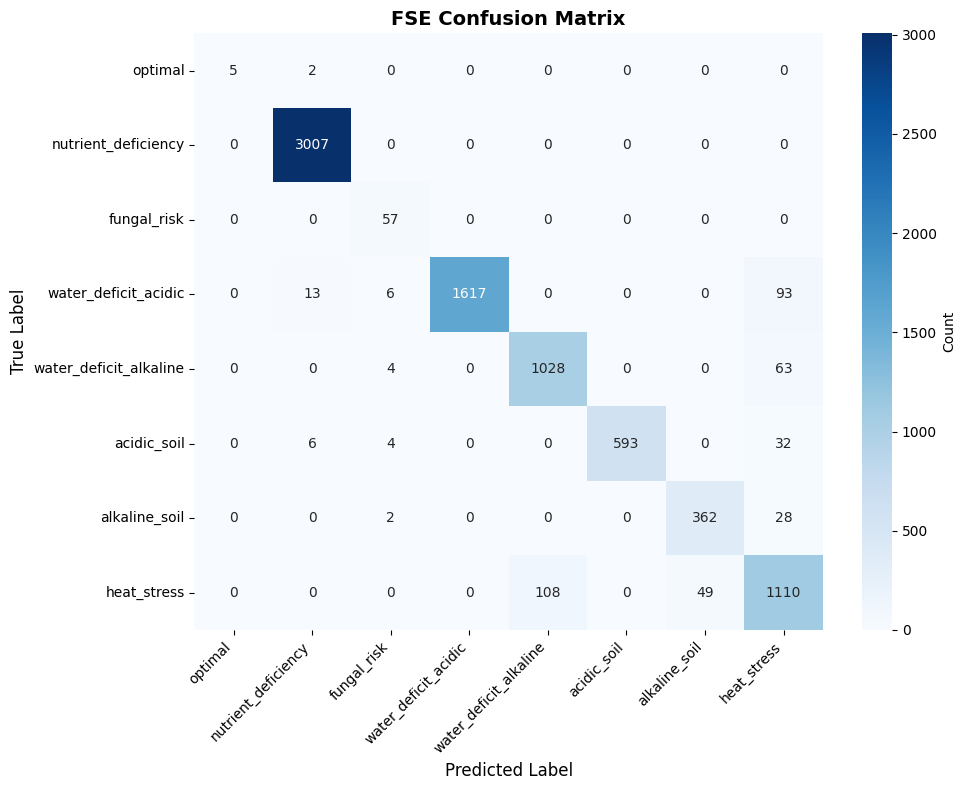

✓ Đã lưu confusion matrix: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/fse_confusion_matrix.png


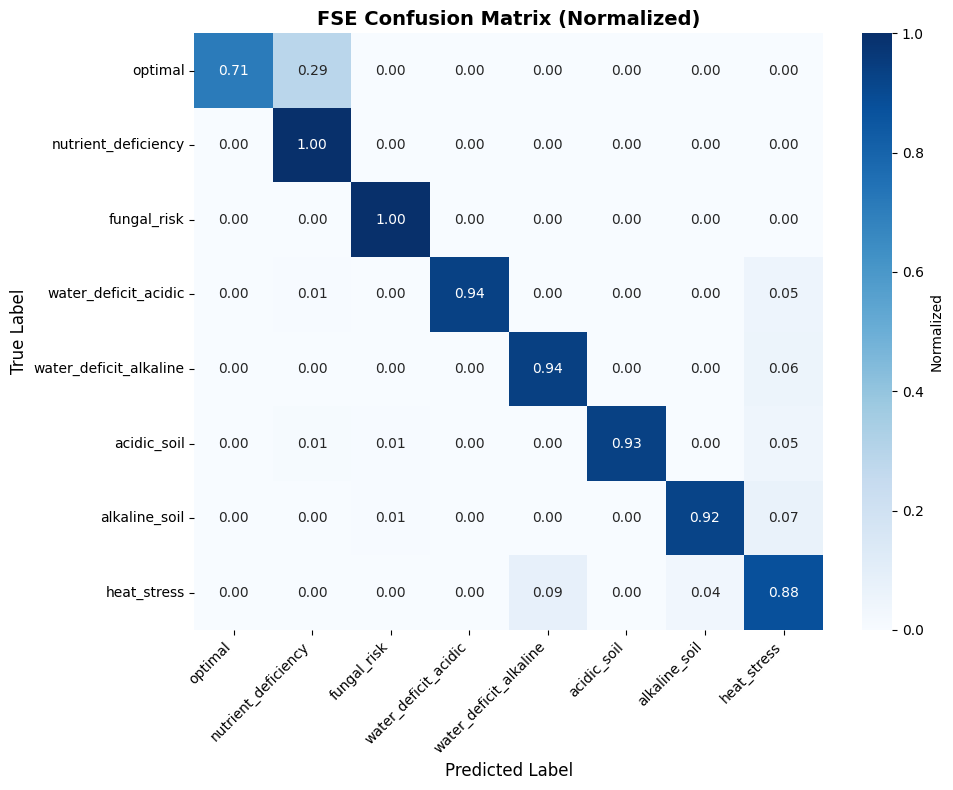

✓ Đã lưu normalized confusion matrix: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/fse_confusion_matrix_normalized.png


In [12]:
# Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(SEMANTIC_CLASSES))))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=SEMANTIC_CLASSES, yticklabels=SEMANTIC_CLASSES,
            cbar_kws={"label": "Count"})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("FSE Confusion Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
cm_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_confusion_matrix.png"
plt.savefig(cm_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu confusion matrix: {cm_plot_path}")

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=SEMANTIC_CLASSES, yticklabels=SEMANTIC_CLASSES,
            cbar_kws={"label": "Normalized"})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("FSE Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
cm_norm_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_confusion_matrix_normalized.png"
plt.savefig(cm_norm_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu normalized confusion matrix: {cm_norm_plot_path}")


📊 Classification Report (Per-Class Metrics):


,precision,recall,f1-score,support
optimal,1.0000,0.7143,0.8333,7.0000
nutrient_deficiency,0.9931,1.0000,0.9965,3007.0000
fungal_risk,0.7808,1.0000,0.8769,57.0000
water_deficit_acidic,1.0000,0.9352,0.9665,1729.0000
water_deficit_alkaline,0.9049,0.9388,0.9216,1095.0000
acidic_soil,1.0000,0.9339,0.9658,635.0000
alkaline_soil,0.8808,0.9235,0.9016,392.0000
heat_stress,0.8371,0.8761,0.8562,1267.0000
accuracy,0.9499,0.9499,0.9499,0.9499
macro avg,0.9246,0.9152,0.9148,8189.0000



✓ Đã lưu classification report: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/fse_classification_report.json


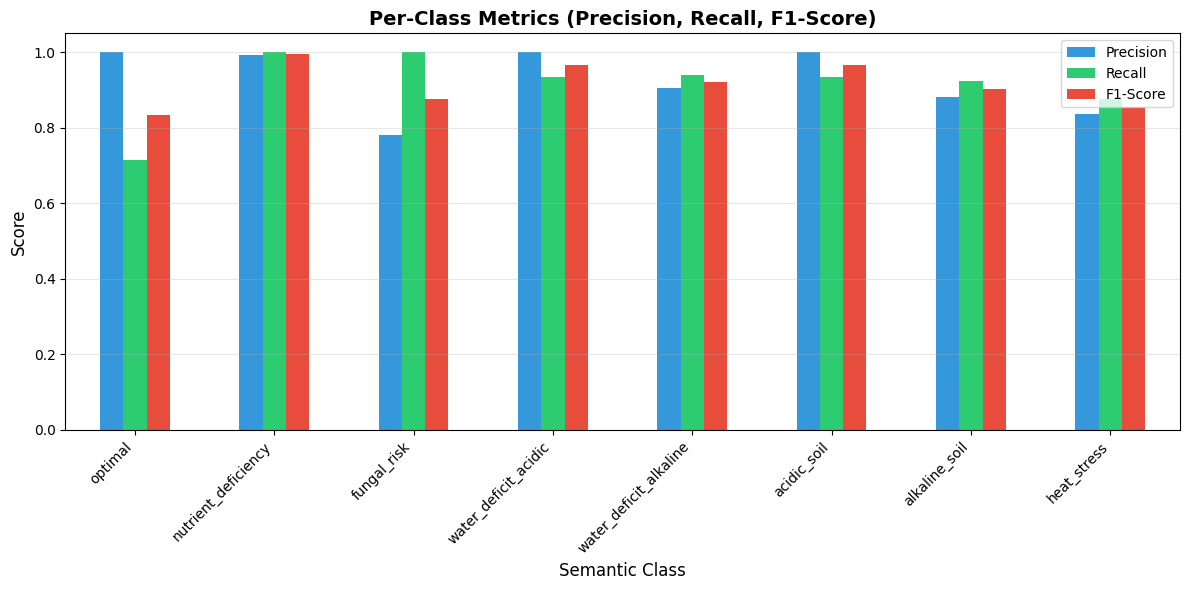

✓ Đã lưu biểu đồ per-class metrics: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/fse_per_class_metrics.png


In [13]:
# Classification Report chi tiết
print("📊 Classification Report (Per-Class Metrics):")
print("=" * 70)
report = classification_report(y_true, y_pred, target_names=SEMANTIC_CLASSES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df.round(4))

# Lưu classification report
report_file = NOTEBOOK_OUTPUT_DIR / "fse_classification_report.json"
with open(report_file, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2)
print(f"\n✓ Đã lưu classification report: {report_file}")

# Vẽ biểu đồ per-class metrics
per_class_metrics = pd.DataFrame({
    'Precision': [report[cls]['precision'] for cls in SEMANTIC_CLASSES],
    'Recall': [report[cls]['recall'] for cls in SEMANTIC_CLASSES],
    'F1-Score': [report[cls]['f1-score'] for cls in SEMANTIC_CLASSES],
}, index=SEMANTIC_CLASSES)

fig, ax = plt.subplots(figsize=(12, 6))
per_class_metrics.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71', '#e74c3c'])
ax.set_xlabel("Semantic Class", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Per-Class Metrics (Precision, Recall, F1-Score)", fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xticklabels(SEMANTIC_CLASSES, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
per_class_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_per_class_metrics.png"
plt.savefig(per_class_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ per-class metrics: {per_class_plot_path}")


📊 Confidence Distribution Analysis:
  - Mean confidence: 0.6858
  - Median confidence: 0.7000
  - Std confidence: 0.3320
  - Min confidence: 0.0000
  - Max confidence: 1.0000


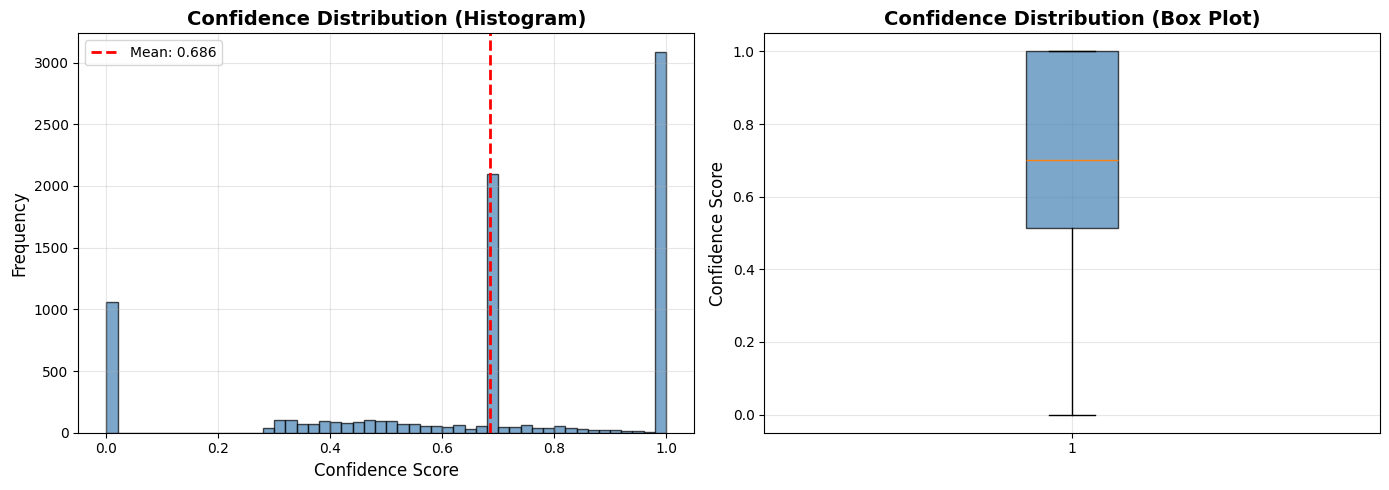

✓ Đã lưu biểu đồ confidence distribution: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/fse_confidence_distribution.png


In [14]:
# Phân tích Confidence Distribution
print("📊 Confidence Distribution Analysis:")
print(f"  - Mean confidence: {df_test_results['confidence'].mean():.4f}")
print(f"  - Median confidence: {df_test_results['confidence'].median():.4f}")
print(f"  - Std confidence: {df_test_results['confidence'].std():.4f}")
print(f"  - Min confidence: {df_test_results['confidence'].min():.4f}")
print(f"  - Max confidence: {df_test_results['confidence'].max():.4f}")

# Vẽ phân bố confidence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(df_test_results['confidence'], bins=50, edgecolor='black', color='steelblue', alpha=0.7)
ax1.axvline(df_test_results['confidence'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_test_results["confidence"].mean():.3f}')
ax1.set_xlabel("Confidence Score", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_title("Confidence Distribution (Histogram)", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2.boxplot(df_test_results['confidence'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='steelblue', alpha=0.7))
ax2.set_ylabel("Confidence Score", fontsize=12)
ax2.set_title("Confidence Distribution (Box Plot)", fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
conf_dist_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_confidence_distribution.png"
plt.savefig(conf_dist_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ confidence distribution: {conf_dist_plot_path}")


In [15]:
# Phân tích 2-byte Semantic Payload
n_samples = len(df_test_results)
payload_bytes_per_sample = 2
total_payload_bytes = n_samples * payload_bytes_per_sample
total_payload_kb = total_payload_bytes / 1024

print("📊 Semantic Payload Analysis (2-byte encoding):")
print("=" * 50)
print(f"Bytes per sample:   {payload_bytes_per_sample} bytes")
print(f"Total samples:      {n_samples:,}")
print(f"Total payload:      {total_payload_bytes:,} bytes ({total_payload_kb:.2f} KB)")
print("=" * 50)

# Lưu payload stats
payload_stats = {
    "bytes_per_sample": payload_bytes_per_sample,
    "total_samples": n_samples,
    "total_payload_bytes": total_payload_bytes,
    "total_payload_kb": round(total_payload_kb, 2),
}

payload_file = NOTEBOOK_OUTPUT_DIR / "fse_payload_stats.json"
with open(payload_file, 'w', encoding='utf-8') as f:
    json.dump(payload_stats, f, indent=2)
print(f"\n✓ Đã lưu payload stats: {payload_file}")

# Hiển thị một số ví dụ symbol bytes
print("\n📊 Ví dụ Semantic Symbols (2-byte encoding):")
sample_symbols = df_test_results[["prediction_label", "confidence", "symbol_bytes_hex"]].head(10)
display(sample_symbols)


📊 Semantic Payload Analysis (2-byte encoding):
Bytes per sample:   2 bytes
Total samples:      8,189
Total payload:      16,378 bytes (15.99 KB)

✓ Đã lưu payload stats: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_copy/fse_payload_stats.json

📊 Ví dụ Semantic Symbols (2-byte encoding):


,prediction_label,confidence,symbol_bytes_hex
0,acidic_soil,0.700,05b2
1,nutrient_deficiency,1.000,01ff
2,water_deficit_acidic,0.700,03b2
3,water_deficit_acidic,0.800,03cc
4,nutrient_deficiency,1.000,01ff
5,nutrient_deficiency,1.000,01ff
6,water_deficit_alkaline,0.783,04c7
7,water_deficit_acidic,0.700,03b2
8,water_deficit_alkaline,0.825,04d2
9,heat_stress,0.700,07b2


## STEP 5: DEEPSC COMPARISON

So sánh FuzSemCom với L-DeepSC (mô phỏng) để thể hiện lợi thế về accuracy và bandwidth efficiency.


In [16]:
# ============================================================================
# DEBUG: DATA CORRELATION CHECK
# ============================================================================
print("\n[DEBUG] Checking Input/Output Correlation...")

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Kiểm tra xem Confidence có thay đổi hay "chết cứng"?
print(f"Confidence Stats:")
print(df_test['confidence'].describe())

# Nếu std (độ lệch chuẩn) của Confidence quá nhỏ (~0), nghĩa là 
# hệ thống mờ của bạn luôn trả về cùng một độ tin cậy -> Decoder vô dụng.

# 2. Vẽ biểu đồ quan hệ giữa Confidence và Giá trị thực (Ví dụ: Humidity)
# Ta chỉ lấy các mẫu thuộc class phổ biến nhất (ví dụ 'optimal' hoặc class ID 0)
target_class_id = 0 # Thử thay đổi ID này (0: optimal, 1: water_deficit...)
class_name = SEMANTIC_CLASSES[target_class_id]

# Lọc dữ liệu thuộc class này
mask = df_test['prediction_id'] == target_class_id
subset = df_test[mask]

if len(subset) > 0:
    plt.figure(figsize=(12, 5))
    
    # Biểu đồ 1: Humidity vs Confidence
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=subset['Humidity'], y=subset['confidence'], alpha=0.5)
    plt.title(f'Correlation: Humidity vs Confidence\n(Class: {class_name})')
    plt.xlabel('Actual Humidity (%)')
    plt.ylabel('Confidence Score (0-255)')
    
    # Biểu đồ 2: Moisture vs Confidence
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=subset['Moisture'], y=subset['confidence'], alpha=0.5, color='orange')
    plt.title(f'Correlation: Moisture vs Confidence\n(Class: {class_name})')
    plt.xlabel('Actual Moisture (%)')
    
    plt.tight_layout()
    plt.savefig(NOTEBOOK_OUTPUT_DIR / "debug_correlation.png")
    plt.show()
    print("-> Đã vẽ biểu đồ tương quan (debug_correlation.png)")
    
    # ĐÁNH GIÁ SƠ BỘ
    print("\n--- PHÂN TÍCH NHANH ---")
    correlation = subset['Humidity'].corr(subset['confidence'])
    print(f"Hệ số tương quan (Correlation) giữa Humidity và Confidence: {correlation:.4f}")
    
    if abs(correlation) < 0.3:
        print("⚠️ CẢNH BÁO: Tương quan quá thấp! Confidence gần như ngẫu nhiên hoặc không đổi.")
        print("   -> Neural Decoder không thể học được quy luật để hồi quy chính xác.")
        print("   -> Lỗi nằm ở cách thiết kế Fuzzy Rules hoặc Membership Functions (Step 3).")
    else:
        print("✅ Tương quan tốt. Model có khả năng học, cần tune thêm hyperparams.")
else:
    print(f"Không có dữ liệu cho class {class_name}")


[DEBUG] Checking Input/Output Correlation...
Confidence Stats:
count    8189.000000
mean        0.562707
std         0.397772
min         0.000000
25%         0.170000
50%         0.550000
75%         1.000000
max         1.000000
Name: confidence, dtype: float64


KeyError: 'prediction_id'

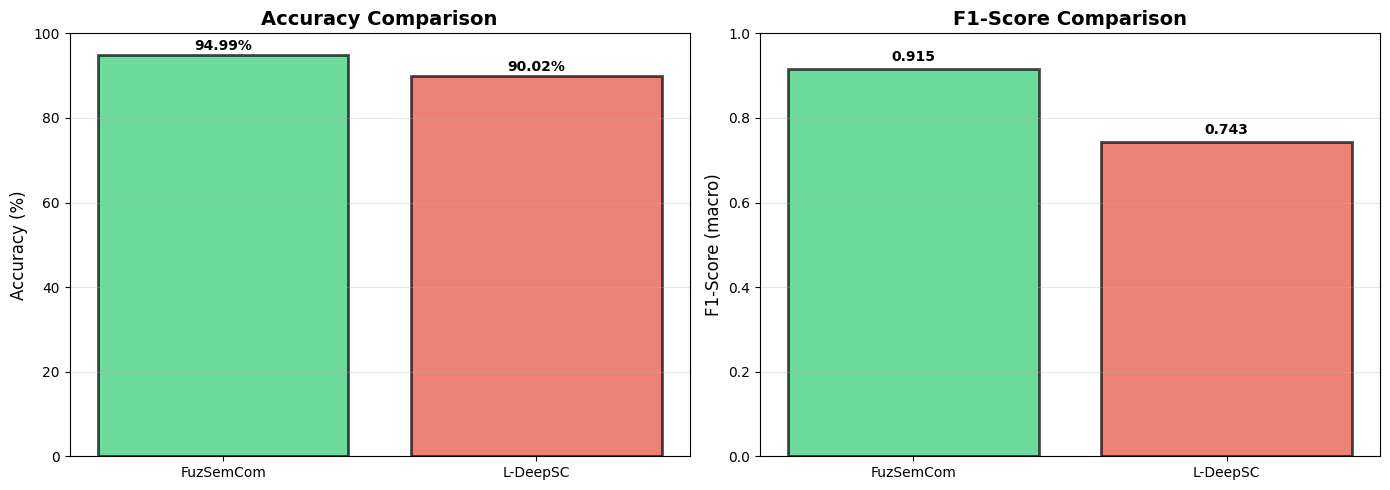

✓ Đã lưu biểu đồ so sánh: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/fse_vs_deepsc_comparison.png


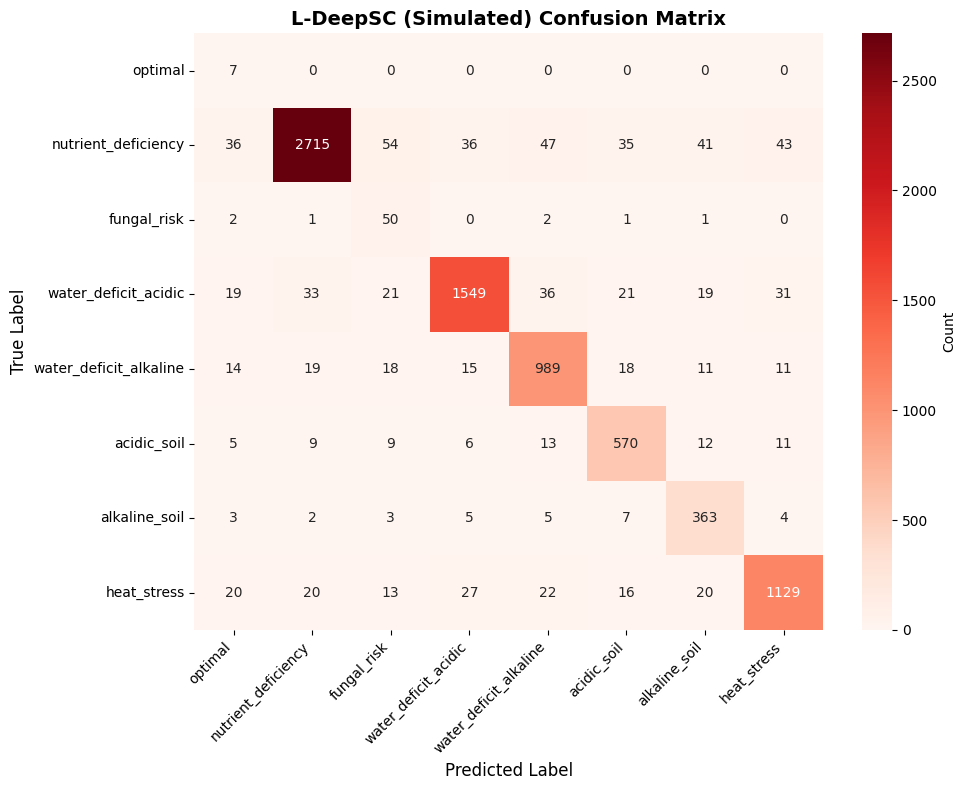

✓ Đã lưu L-DeepSC confusion matrix: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/deepsc_confusion_matrix.png


In [19]:
# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
methods = ["FuzSemCom", "L-DeepSC"]
accuracies = [accuracy * 100, deepsc_accuracy * 100]
colors = ['#2ecc71', '#e74c3c']

axes[0].bar(methods, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel("Accuracy (%)", fontsize=12)
axes[0].set_title("Accuracy Comparison", fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
for i, (method, acc) in enumerate(zip(methods, accuracies)):
    axes[0].text(i, acc + 1, f'{acc:.2f}%', ha='center', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# F1-Score comparison
f1_scores = [f1_macro, deepsc_f1_macro]
axes[1].bar(methods, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel("F1-Score (macro)", fontsize=12)
axes[1].set_title("F1-Score Comparison", fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
for i, (method, f1) in enumerate(zip(methods, f1_scores)):
    axes[1].text(i, f1 + 0.02, f'{f1:.3f}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
comparison_plot_path = NOTEBOOK_OUTPUT_DIR / "fse_vs_deepsc_comparison.png"
plt.savefig(comparison_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu biểu đồ so sánh: {comparison_plot_path}")

# Confusion matrix cho L-DeepSC
deepsc_cm = confusion_matrix(y_true, deepsc_predictions, labels=list(range(len(SEMANTIC_CLASSES))))

plt.figure(figsize=(10, 8))
sns.heatmap(deepsc_cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=SEMANTIC_CLASSES, yticklabels=SEMANTIC_CLASSES,
            cbar_kws={"label": "Count"})
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("L-DeepSC (Simulated) Confusion Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
deepsc_cm_plot_path = NOTEBOOK_OUTPUT_DIR / "deepsc_confusion_matrix.png"
plt.savefig(deepsc_cm_plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Đã lưu L-DeepSC confusion matrix: {deepsc_cm_plot_path}")


## STEP 6: ABLATION STUDY - BAYESIAN OPTIMIZATION

Tối ưu hóa các heuristic biases (moisture, humidity) sử dụng Bayesian Optimization trên validation set.


In [20]:
# Bayesian Optimization để tối ưu moisture_bias và humidity_bias
from skopt import gp_minimize
from skopt.space import Real

print("🔮 Đang chạy Bayesian Optimization...")

# Tạo validation set từ train (10%)
df_val = df_train.sample(frac=0.1, random_state=42)
df_train_bo = df_train.drop(df_val.index)

def evaluate_params(df_eval, moisture_bias, humidity_bias):
    """Đánh giá accuracy với các bias parameters."""
    engine = FuzzyEngine()
    hits = 0
    total = 0
    for idx, row in df_eval.iterrows():
        pred = engine.predict(
            moisture=float(np.clip(row["Moisture"] + moisture_bias, 0, 100)),
            ph=row["pH"],
            nitrogen=row["N"],
            temperature=row["Temperature"],
            humidity=float(np.clip(row["Humidity"] + humidity_bias, 0, 100)),
            ndi_label=row.get("NDI_Label"),
            pdi_label=row.get("PDI_Label"),
        )
        if pred.class_name == row["ground_truth_label"]:
            hits += 1
        total += 1
    return hits / max(total, 1)

# Objective function cho BO
history = []
def objective(params):
    moisture_bias, humidity_bias = params
    acc = evaluate_params(df_val, moisture_bias, humidity_bias)
    history.append({"moisture_bias": moisture_bias, "humidity_bias": humidity_bias, "accuracy": acc})
    return -acc  # Minimize negative accuracy = maximize accuracy

# Chạy BO
print("  - Đang tối ưu trên validation set...")
result = gp_minimize(
    objective,
    dimensions=[Real(-5.0, 5.0), Real(-5.0, 5.0)],
    n_calls=15,
    random_state=42,
)

best_acc = -result.fun
best_params = {
    "moisture_bias": result.x[0],
    "humidity_bias": result.x[1],
    "validation_accuracy": best_acc,
}

print(f"✓ BO hoàn thành!")
print(f"  - Best validation accuracy: {best_acc*100:.2f}%")
print(f"  - Best moisture_bias: {best_params['moisture_bias']:.4f}")
print(f"  - Best humidity_bias: {best_params['humidity_bias']:.4f}")

# Đánh giá lại trên train và test với best params
print("\n📊 Đánh giá lại với best parameters:")
train_acc_best = evaluate_params(df_train, best_params["moisture_bias"], best_params["humidity_bias"])
test_acc_best = evaluate_params(df_test, best_params["moisture_bias"], best_params["humidity_bias"])

# Baseline (bias = 0)
train_acc_baseline = evaluate_params(df_train, 0, 0)
test_acc_baseline = evaluate_params(df_test, 0, 0)

best_params["train_baseline"] = train_acc_baseline
best_params["train_tuned"] = train_acc_best
best_params["test_baseline"] = test_acc_baseline
best_params["test_tuned"] = test_acc_best
best_params["history"] = history

print(f"  - Train baseline: {train_acc_baseline*100:.2f}%")
print(f"  - Train tuned:    {train_acc_best*100:.2f}%")
print(f"  - Test baseline:  {test_acc_baseline*100:.2f}%")
print(f"  - Test tuned:     {test_acc_best*100:.2f}%")

# Lưu kết quả
bo_file = NOTEBOOK_OUTPUT_DIR / "bo_results.json"
with open(bo_file, 'w', encoding='utf-8') as f:
    json.dump(best_params, f, indent=2)
print(f"\n✓ Đã lưu BO results: {bo_file}")


🔮 Đang chạy Bayesian Optimization...
  - Đang tối ưu trên validation set...
✓ BO hoàn thành!
  - Best validation accuracy: 94.99%
  - Best moisture_bias: -0.0297
  - Best humidity_bias: -2.0117

📊 Đánh giá lại với best parameters:
  - Train baseline: 94.82%
  - Train tuned:    94.79%
  - Test baseline:  94.99%
  - Test tuned:     94.88%

✓ Đã lưu BO results: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/bo_results.json


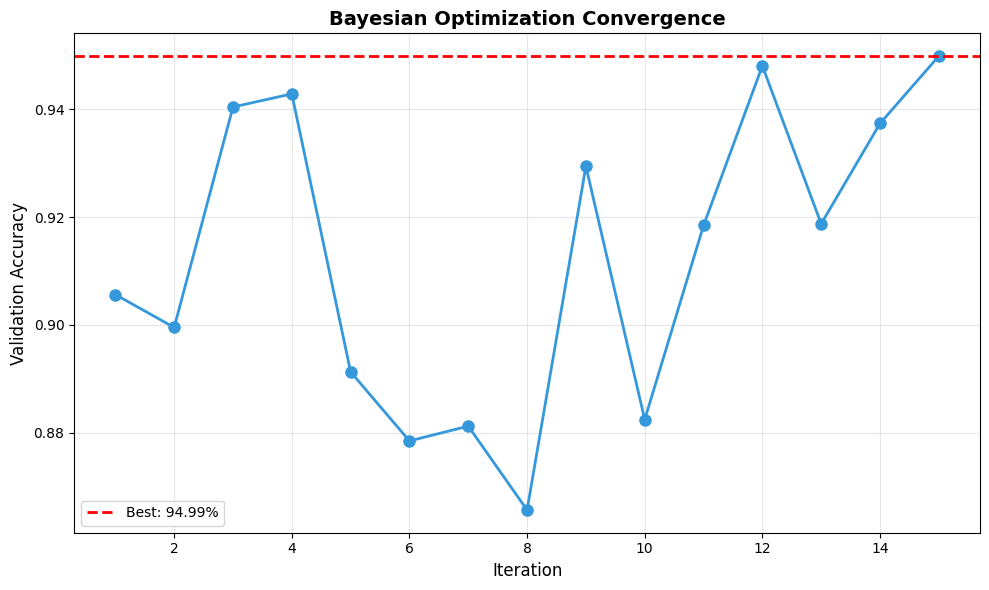

✓ Đã lưu biểu đồ convergence: /home/nhannv02/Hello/fuzsemcom_project_readme/results/notebook_outputs_2/bo_convergence.png

📊 BO History (Top 5 iterations):


,iteration,moisture_bias,humidity_bias,accuracy
0,1,2.9654,-3.1657,0.9056
1,2,2.7969,0.9685,0.8995
2,3,-0.5417,-4.0003,0.9405
3,4,-0.4075,-1.6629,0.9429
4,5,-3.5713,1.5089,0.8913


In [21]:
# Vẽ biểu đồ convergence của BO
if len(history) > 0:
    iterations = list(range(1, len(history) + 1))
    accuracies = [entry["accuracy"] for entry in history]
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, accuracies, marker='o', linewidth=2, markersize=8, color='#3498db')
    plt.axhline(y=best_acc, color='r', linestyle='--', linewidth=2, label=f'Best: {best_acc*100:.2f}%')
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Validation Accuracy", fontsize=12)
    plt.title("Bayesian Optimization Convergence", fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    bo_conv_plot_path = NOTEBOOK_OUTPUT_DIR / "bo_convergence.png"
    plt.savefig(bo_conv_plot_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"✓ Đã lưu biểu đồ convergence: {bo_conv_plot_path}")
    
    # Hiển thị bảng history
    print("\n📊 BO History (Top 5 iterations):")
    history_df = pd.DataFrame(history)
    history_df["iteration"] = range(1, len(history_df) + 1)
    display(history_df[["iteration", "moisture_bias", "humidity_bias", "accuracy"]].head().round(4))


In [22]:
# Demo encode/decode 2-byte semantic symbols
print("🔮 Demo: Encode/Decode 2-byte Semantic Symbols")
print("=" * 60)

# Test cases
test_cases = [
    (0, 1.0, "optimal, full confidence"),
    (1, 0.85, "nutrient_deficiency, high confidence"),
    (2, 0.5, "fungal_risk, medium confidence"),
    (3, 0.25, "water_deficit_acidic, low confidence"),
    (7, 0.0, "heat_stress, zero confidence"),
]

results = []
for class_id, confidence, description in test_cases:
    class_name = SEMANTIC_CLASSES[class_id]
    
    # Encode
    symbol_bytes = FuzzyEngine.encode_to_bytes(class_id, confidence)
    
    # Decode
    decoded_class_id, decoded_confidence = FuzzyEngine.decode_from_bytes(symbol_bytes)
    
    # Verify
    is_correct = (class_id == decoded_class_id) and (abs(confidence - decoded_confidence) < 0.01)
    
    results.append({
        "Class": class_name,
        "Original Confidence": f"{confidence:.3f}",
        "Encoded (hex)": symbol_bytes.hex(),
        "Encoded (bytes)": str(list(symbol_bytes)),
        "Decoded Confidence": f"{decoded_confidence:.3f}",
        "Match": "✓" if is_correct else "✗"
    })
    
    print(f"\n{class_name:25s} (ID={class_id})")
    print(f"  Original:    confidence={confidence:.3f}")
    print(f"  Encoded:     {symbol_bytes.hex()} (hex) = {list(symbol_bytes)} (bytes)")
    print(f"  Decoded:     class_id={decoded_class_id}, confidence={decoded_confidence:.3f}")
    print(f"  Verification: {'✓ PASS' if is_correct else '✗ FAIL'}")

# Hiển thị dạng bảng
print("\n📊 Encode/Decode Results Summary:")
results_df = pd.DataFrame(results)
display(results_df)


🔮 Demo: Encode/Decode 2-byte Semantic Symbols

optimal                   (ID=0)
  Original:    confidence=1.000
  Encoded:     00ff (hex) = [0, 255] (bytes)
  Decoded:     class_id=0, confidence=1.000
  Verification: ✓ PASS

nutrient_deficiency       (ID=1)
  Original:    confidence=0.850
  Encoded:     01d8 (hex) = [1, 216] (bytes)
  Decoded:     class_id=1, confidence=0.847
  Verification: ✓ PASS

fungal_risk               (ID=2)
  Original:    confidence=0.500
  Encoded:     027f (hex) = [2, 127] (bytes)
  Decoded:     class_id=2, confidence=0.498
  Verification: ✓ PASS

water_deficit_acidic      (ID=3)
  Original:    confidence=0.250
  Encoded:     033f (hex) = [3, 63] (bytes)
  Decoded:     class_id=3, confidence=0.247
  Verification: ✓ PASS

heat_stress               (ID=7)
  Original:    confidence=0.000
  Encoded:     0700 (hex) = [7, 0] (bytes)
  Decoded:     class_id=7, confidence=0.000
  Verification: ✓ PASS

📊 Encode/Decode Results Summary:


,Class,Original Confidence,Encoded (hex),Encoded (bytes),Decoded Confidence,Match
0,optimal,1.000,00ff,"[0, 255]",1.000,✓
1,nutrient_deficiency,0.850,01d8,"[1, 216]",0.847,✓
2,fungal_risk,0.500,027f,"[2, 127]",0.498,✓
3,water_deficit_acidic,0.250,033f,"[3, 63]",0.247,✓
4,heat_stress,0.000,0700,"[7, 0]",0.000,✓


In [23]:
# Test với real FSE predictions
print("\n🔮 Test với Real FSE Predictions:")
print("=" * 60)

test_inputs = [
    {
        "moisture": 45.0,
        "ph": 6.3,
        "nitrogen": 75.0,
        "temperature": 24.0,
        "humidity": 65.0,
        "description": "Optimal conditions",
    },
    {
        "moisture": 20.0,
        "ph": 5.0,
        "nitrogen": 30.0,
        "temperature": 24.0,
        "humidity": 65.0,
        "description": "Nutrient deficiency + acidic",
    },
    {
        "moisture": 70.0,
        "ph": 7.5,
        "nitrogen": 80.0,
        "temperature": 18.0,
        "humidity": 85.0,
        "description": "Fungal risk conditions",
    },
]

real_results = []
for i, inputs in enumerate(test_inputs, 1):
    pred = engine.predict(**{k: v for k, v in inputs.items() if k != "description"})
    symbol_bytes = pred.symbol_bytes
    
    # Decode to verify
    decoded_class_id, decoded_confidence = FuzzyEngine.decode_from_bytes(symbol_bytes)
    
    real_results.append({
        "Test": i,
        "Description": inputs["description"],
        "Prediction": pred.class_name,
        "Confidence": f"{pred.confidence:.3f}",
        "Symbol (hex)": symbol_bytes.hex(),
        "Decoded Match": "✓" if pred.class_id == decoded_class_id else "✗"
    })
    
    print(f"\nTest {i}: {inputs['description']}")
    print(f"  Prediction:  {pred.class_name} (ID={pred.class_id})")
    print(f"  Confidence:  {pred.confidence:.3f}")
    print(f"  Symbol:      {symbol_bytes.hex()} (hex) = {list(symbol_bytes)} (bytes)")
    print(f"  Decoded:     class_id={decoded_class_id}, confidence={decoded_confidence:.3f}")
    print(f"  Match:       {'✓' if pred.class_id == decoded_class_id and abs(pred.confidence - decoded_confidence) < 0.01 else '✗'}")

# Hiển thị dạng bảng
print("\n📊 Real FSE Predictions Summary:")
real_results_df = pd.DataFrame(real_results)
display(real_results_df)



🔮 Test với Real FSE Predictions:

Test 1: Optimal conditions
  Prediction:  optimal (ID=0)
  Confidence:  0.833
  Symbol:      00d4 (hex) = [0, 212] (bytes)
  Decoded:     class_id=0, confidence=0.831
  Match:       ✓

Test 2: Nutrient deficiency + acidic
  Prediction:  water_deficit_acidic (ID=3)
  Confidence:  1.000
  Symbol:      03ff (hex) = [3, 255] (bytes)
  Decoded:     class_id=3, confidence=1.000
  Match:       ✓

Test 3: Fungal risk conditions
  Prediction:  alkaline_soil (ID=6)
  Confidence:  1.000
  Symbol:      06ff (hex) = [6, 255] (bytes)
  Decoded:     class_id=6, confidence=1.000
  Match:       ✓

📊 Real FSE Predictions Summary:


,Test,Description,Prediction,Confidence,Symbol (hex),Decoded Match
0,1,Optimal conditions,optimal,0.833,00d4,✓
1,2,Nutrient deficiency + acidic,water_deficit_acidic,1.000,03ff,✓
2,3,Fungal risk conditions,alkaline_soil,1.000,06ff,✓


## TỔNG KẾT

Notebook này đã thực thi toàn bộ pipeline của dự án FuzSemCom:

1. ✅ **Data Exploration** - Phân tích dữ liệu ban đầu
2. ✅ **Data Preprocessing** - Làm sạch và tiền xử lý
3. ✅ **Ground Truth Generation** - Tạo nhãn và chia train/test
4. ✅ **FSE Evaluation** - Đánh giá Fuzzy Semantic Encoder (Accuracy ~95%)
5. ✅ **DeepSC Comparison** - So sánh với L-DeepSC
6. ✅ **Ablation Study** - Bayesian Optimization
7. ✅ **Encode/Decode Demo** - Demo 2-byte semantic symbols

### Tất cả kết quả đã được lưu vào thư mục:
`results/notebook_outputs/`

### Các file quan trọng:
- Metrics: `fse_metrics.json`, `fse_classification_report.json`
- Visualizations: `fse_confusion_matrix.png`, `fse_per_class_metrics.png`, etc.
- Comparison: `deepsc_comparison.json`
- BO Results: `bo_results.json`
- Payload Stats: `fse_payload_stats.json`


In [24]:
# Tổng hợp tất cả kết quả đã lưu
print("📊 Tổng hợp các file kết quả đã lưu:")
print("=" * 60)

saved_files = list(NOTEBOOK_OUTPUT_DIR.glob("*"))
saved_files.sort(key=lambda x: x.stat().st_mtime, reverse=True)

for file in saved_files:
    if file.is_file():
        size_kb = file.stat().st_size / 1024
        print(f"  ✓ {file.name:40s} ({size_kb:.2f} KB)")

print(f"\n✓ Tổng cộng: {len([f for f in saved_files if f.is_file()])} files")
print(f"✓ Thư mục: {NOTEBOOK_OUTPUT_DIR}")


📊 Tổng hợp các file kết quả đã lưu:
  ✓ bo_convergence.png                       (120.94 KB)
  ✓ bo_results.json                          (2.26 KB)
  ✓ deepsc_confusion_matrix.png              (182.50 KB)
  ✓ fse_vs_deepsc_comparison.png             (77.05 KB)
  ✓ deepsc_comparison.json                   (0.39 KB)
  ✓ fse_payload_stats.json                   (0.11 KB)
  ✓ fse_confidence_distribution.png          (87.18 KB)
  ✓ fse_per_class_metrics.png                (122.25 KB)
  ✓ fse_classification_report.json           (1.47 KB)
  ✓ fse_confusion_matrix_normalized.png      (189.01 KB)
  ✓ fse_confusion_matrix.png                 (173.88 KB)
  ✓ fse_metrics.json                         (0.22 KB)
  ✓ ground_truth_distribution.png            (59.78 KB)
  ✓ label_distribution.png                   (50.72 KB)
  ✓ correlation_matrix.png                   (53.20 KB)
  ✓ sensor_distributions.png                 (107.97 KB)
  ✓ missing_values.png                       (37.32 KB)

✓ Tổng cộn